In [2]:
import numpy as np
import scipy.constants as cc

from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from RachbaJunction import RachbaJunction
from RachbaJunction.utilities import *
from RachbaJunction.ScatteringMatrix import ScatteringMatrix

In [16]:
ee = 0
al_r = 10

alpha = [al_r, 0, -al_r]

phi = 2/(np.sqrt(al_r))
# phi = .18*np.pi
print(phi)

x_1 = -2
x_2 = phi - x_1
profile = [0, phi]

junction = RachbaJunction([profile, alpha], logg = False)
S = junction.get_scattering_matrix(ee)
M = junction.transfer_matrix_at(0, ee)


def t_region_WF(x, E, a = [1, 0]):
    # left part
    if x <= junction.interface[0]:
        junction.E_so = junction[0]
        wf = junction.get_WF(x, E)
        injected = a[0]*wf[:, 0]
        reflected = np.dot(S.C, np.array(a))[0]*wf[:, 1]
        evanescent = np.dot(S.C, np.array(a))[2]*wf[:, 2]
        res = injected + reflected + evanescent
    
    elif junction.interface[0] < x < junction.interface[1]:
        junction.E_so = junction[1]
        wf = junction.get_WF(x, E)
        
        coeff = np.dot(S.C, np.array(a))
        
        left_coeff = np.array([1, coeff[0], coeff[2], 0])
        
        res = np.dot(wf, np.dot(M, left_coeff))
        
#         if np.isclose(x, 0, atol = 1e-3):
#             print(np.dot(M, left_coeff))
    elif x > junction.interface[1]:
        junction.E_so = junction[2]    
        wf = junction.get_WF(x, E)

        injected = a[1]*wf[:, 1]
        reflected = np.dot(S.C, np.array(a))[1]*wf[:, 0]
        evanescent = np.dot(S.C, np.array(a))[3]*wf[:, 3]
        res = injected + reflected + evanescent
    return res

    
real_1 = []
imag_1 = []

real_2 = []
imag_2 = []

x_range = np.arange(x_1, x_2, 0.00011)

total_wf = np.zeros((len(x_range), 2), dtype = np.complex256)
# x_range = np.arange(-2.5, 2.5, 0.001)
j = 0
for xx in x_range:
    r = t_region_WF(xx, ee, a=[1,0])
    total_wf[j] = r
    real_1.append(r[0].real)
    real_2.append(r[1].real)
    
    imag_1.append(r[0].imag)
    imag_2.append(r[1].imag)
    j +=1

0.6324555320336759


<IPython.core.display.Javascript object>


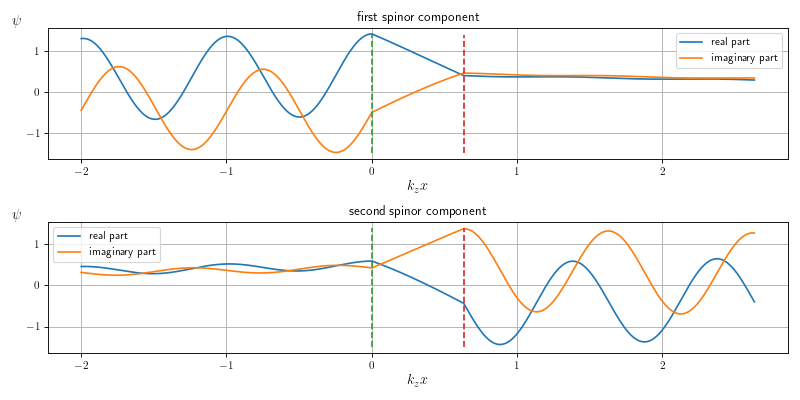

In [17]:
# %matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 1, figsize=(10, 5), dpi=100, tight_layout=True, facecolor='white')

y_int = np.arange(-1.5, 1.5, 0.1)
# d_wf = np.gradient(total_wf, x_range, axis = 0)
# d_wf = base_current(x_range, total_wf)
# d_wf = spin_density(total_wf, SIG_z)


axs_title = ["first spinor component", "second spinor component"]

for j in range(total_wf.shape[1]):
    axs[j].plot(x_range, total_wf[:, j].real, label="real part")
    axs[j].plot(x_range, total_wf[:, j].imag, label="imaginary part")

#     axs[j].plot(x_range, d_wf.imag, label="d real part")
#     axs[j].plot(x_range, d_wf.real, label="d real part")


#     axs[j].plot(x_range, d_wf[:, j].real, label="d real part")
#     axs[j].plot(x_range, d_wf[:, j].imag, label="d imaginary part")

    axs[j].plot(np.full(len(y_int), 0), [i for i in y_int], linestyle = "dashed")
    axs[j].plot(np.full(len(y_int), phi), [i for i in y_int], linestyle = "dashed")
        
    axs[j].set_title(axs_title[j])
        
    axs[j].set_xlabel(r"$k_z x$", fontsize=13)
    axs[j].set_ylabel(r"$\psi$", loc = 'top', rotation=0, fontsize=13)
    axs[j].legend()
    axs[j].grid(True)

    
# plt.savefig("plots/Report/Dirac_dilema_wavefuncton.pdf", transparent = True)
plt.show()

In [18]:
m = 0.015*cc.m_e
ev_to_j = 1.602176634e-19

SIG_z = np.array([[1, 0], [0, -1]])
SIG_x = np.array([[0, 1], [1, 0]])
SIG_y = np.array([[0, -complex(0,1)], [complex(0, 1), 0]])


def base_current(x, wf):
    d_wf = np.gradient(wf, x, axis = 0)
    
    res = np.zeros(len(x), dtype = np.complex256)
    s = 0
    for i, j in zip(wf, d_wf):
        res[s] = np.dot(np.conjugate(i), j) - np.dot(np.conjugate(j), i)
        s += 1
    return res

def spin_density(wf, sig):
    res = np.zeros(wf.shape[0], dtype = np.complex256)
    s = 0
    for i in wf:
        res[s] = np.dot(np.conjugate(i), np.dot(sig, i))
        s += 1
    return res

def charge_current(x, wf, junc, m = 0.015*cc.m_e, h = 1e-3):
    # [j] = C*m/s
    
    k_z = np.sqrt(2*m*h*ev_to_j)/cc.hbar
    pos = 0
    e_so = junc[pos]
    x_0 = junc.interface[pos]
    j = 0
    res = spin_density(wf, SIG_z)#np.zeros(len(x), dtype = np.complex256)
    for i in x:
        if i > x_0:
            e_so = junc[pos]
            if len(junc.interface) > pos+1:
                pos+=1
                e_so = junc[pos]
                x_0 = junc.interface[pos]
            else:
                pos+=1
                e_so = junc[pos]
                x_0 = np.max(x) + 100
            
#         print(x_0, pos, e_so)
        res[j] = cc.e*np.sign(e_so)*np.sqrt(2*h*ev_to_j/m * np.abs(e_so))*res[j]
        j+=1
    return k_z*cc.e * cc.hbar/(2*m) * base_current(x, wf).imag - res
    

<IPython.core.display.Javascript object>


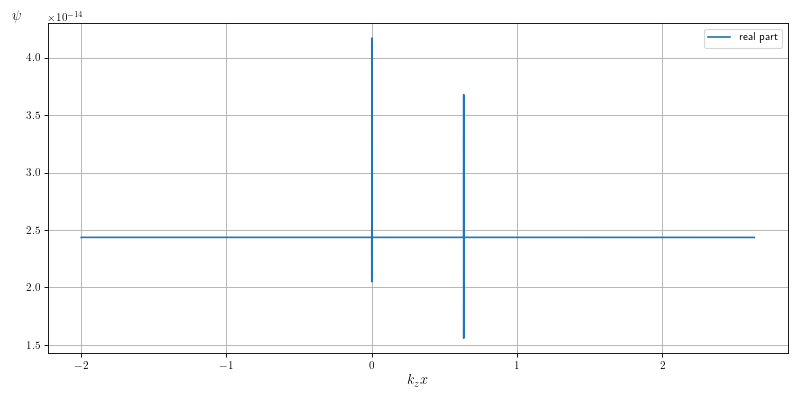

In [19]:
j_e = charge_current(x_range, total_wf, junction, h = 0.1e-3).real


%matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=100, tight_layout=True, facecolor='white')
axs = [axs]
axs[0].plot(x_range, j_e, label="real part")

for i in axs:
    i.set_xlabel(r"$k_z x$", fontsize=13)
    i.set_ylabel(r"$\psi$", loc = 'top', rotation=0, fontsize=13)
    i.legend()
    i.grid(True)
    
# plt.savefig("plots/Report/Dirac_dilema_wavefuncton.pdf", transparent = True)
plt.show()

In [597]:
print(cc.e, cc.hbar)

print(charge_current(x_range, total_wf, junction, h = 0.1e-3))

1.602176634e-19 1.0545718176461565e-34
[-6.09087274e-16+0.j -4.71158566e-16+0.j -3.31877620e-16+0.j
 -1.91798658e-16+0.j -5.14808708e-17+0.j  8.85138253e-17+0.j
  2.27623029e-16+0.j  3.65286109e-16+0.j  5.00946458e-16+0.j
  6.34053738e-16+0.j  7.64066105e-16+0.j  8.90452411e-16+0.j
  1.01269437e-15+0.j  1.13028866e-15+0.j  1.24274902e-15+0.j
  1.34960823e-15+0.j  1.45042005e-15+0.j  1.54476107e-15+0.j
  1.63223250e-15+0.j  1.71246183e-15+0.j  1.78510441e-15+0.j
  1.84984492e-15+0.j  1.90639873e-15+0.j  1.95451314e-15+0.j
  1.99396849e-15+0.j  2.02457914e-15+0.j  2.04619435e-15+0.j
  2.05869895e-15+0.j  2.06201395e-15+0.j  2.05609697e-15+0.j
  2.04094249e-15+0.j  2.01658205e-15+0.j  1.98308417e-15+0.j
  1.94055425e-15+0.j  1.88913424e-15+0.j  1.82900218e-15+0.j
  1.76037162e-15+0.j  1.68349086e-15+0.j  1.59864206e-15+0.j
  1.50614024e-15+0.j  1.40633210e-15+0.j  1.29959474e-15+0.j
  1.18633423e-15+0.j  1.06698409e-15+0.j  9.42003634e-16+0.j
  8.11876209e-16+0.j  6.77107326e-16+0.j  5.38

(1.4319658946341222107+0j)
(1.407228125657606261+0j)
(1.3807760320949111218+0j)
(1.3527102586669975209+0j)
(1.3231382396143562822+0j)
(1.2921737893837998675+0j)
(1.2599366664346575793+0j)
(1.2265521118283732038+0j)
(1.1921503643719513714+0j)
(1.1568661541852579078+0j)
(1.1208381766546727742+0j)
(1.0842085488204078221+0j)
(1.0471222503217890647+0j)
(1.0097265510933912139+0j)
(0.97217042806501454967+0j)
(0.93460397316973277274+0j)
(0.89717779500634065856+0j)
(0.8600424165354841282+0j)
(0.82334767121211696074+0j)
(0.78724209997086154266+0j)
(0.75187235148502963404+0j)
(0.71738258811466749904+0j)
(0.6839138999437540529+0j)
(0.6516037292818798992+0j)
(0.6205853079713013693+0j)
(0.59098710979627795345+0j)
(0.5629323202383879008+0j)
(0.53653832575899205196+0j)
(0.51191622471867141155+0j)
(0.48917036196333168614+0j)
(0.46839788901825027843+0j)
(0.44968835173474332254+0j)
(0.4331233071299212116+0j)
(0.41877597104843805088+0j)
(0.4067108981566909309+0j)
(0.3969836956550803873+0j)
(0.389640771963

<IPython.core.display.Javascript object>


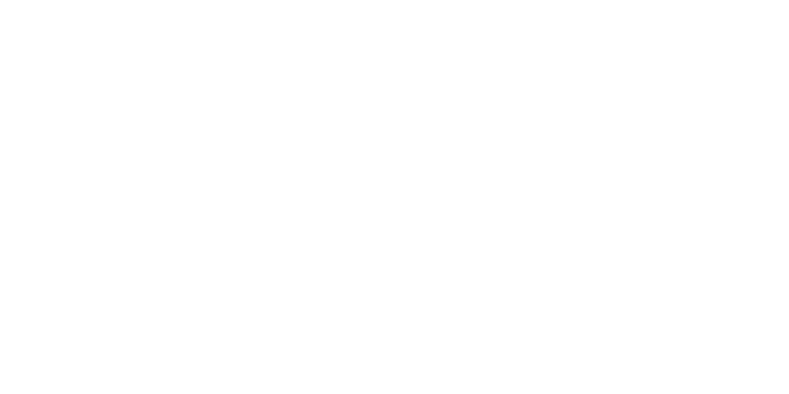

In [457]:
# np.conjugate(total_wf)

wf_norm = []
for i in total_wf:
    print(np.dot(np.conjugate(i), np.dot(SIG_z, i)))
    wf_norm.append(np.dot(np.conjugate(i), i).real)
    
d_wf = np.gradient(total_wf, x_range, axis = 0)
# print(d_wf)
print(total_wf.shape)
    
# %matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=100, tight_layout=True, facecolor='white')
axs = [axs]
axs[0].plot(x_range, wf_norm, label="real part")

for i in axs:
    i.set_xlabel(r"$k_z x$", fontsize=13)
    i.set_ylabel(r"$\psi$", loc = 'top', rotation=0, fontsize=13)
    i.legend()
    i.grid(True)
    
# plt.savefig("plots/Report/Dirac_dilema_wavefuncton.pdf", transparent = True)
plt.show()

In [33]:
ee = 0
al_r = 100

alpha = [al_r, 0, -al_r]

# phi = [.565, .06]
phi = [2/(np.sqrt(al_r)), .06]
print(phi)

x_1 = -2
x_2 = 2
profile = [0, 1]

junction = RachbaJunction([profile, alpha])
S = junction.get_scattering_matrix(ee)
M = junction.transfer_matrix_at(0, ee)


def t_region_WF(x, E, a = [1, 0]):
    # left part
    if x <= junction.interface[0]:
        junction.E_so = junction[0]
        wf = junction.get_WF(x, E)
        injected = a[0]*wf[:, 0]
        reflected = np.dot(S.C, np.array(a))[0]*wf[:, 1]
        evanescent = np.dot(S.C, np.array(a))[2]*wf[:, 2]
        res = injected + reflected + evanescent
    
    elif junction.interface[0] < x < junction.interface[1]:
        junction.E_so = junction[1]
        wf = junction.get_WF(x, E)
        
        coeff = np.dot(S.C, np.array(a))
        
        left_coeff = np.array([1, coeff[0], coeff[2], 0])
        
        res = np.dot(wf, np.dot(M, left_coeff))
        
#         if np.isclose(x, 0, atol = 1e-3):
#             print(np.dot(M, left_coeff))
    elif x > junction.interface[1]:
        junction.E_so = junction[2]    
        wf = junction.get_WF(x, E)

        injected = a[1]*wf[:, 1]
        reflected = np.dot(S.C, np.array(a))[1]*wf[:, 0]
        evanescent = np.dot(S.C, np.array(a))[3]*wf[:, 3]
        res = injected + reflected + evanescent
    return res

    

x_range = np.arange(x_1, x_2, 0.01)

total_wf1 = np.zeros((len(x_range), 2), dtype = np.complex256)
total_wf2 = np.zeros((len(x_range), 2), dtype = np.complex256)

res = {k: v for k, v in zip(phi, [total_wf1, total_wf2])}


for p in phi:
    junction.interface = [0, p]
    S = junction.get_scattering_matrix(ee)
    M = junction.transfer_matrix_at(0, ee)
    for j, xx in enumerate(x_range):
        r = t_region_WF(xx, ee)
        res[p][j] = r

[0.2, 0.06]


<IPython.core.display.Javascript object>


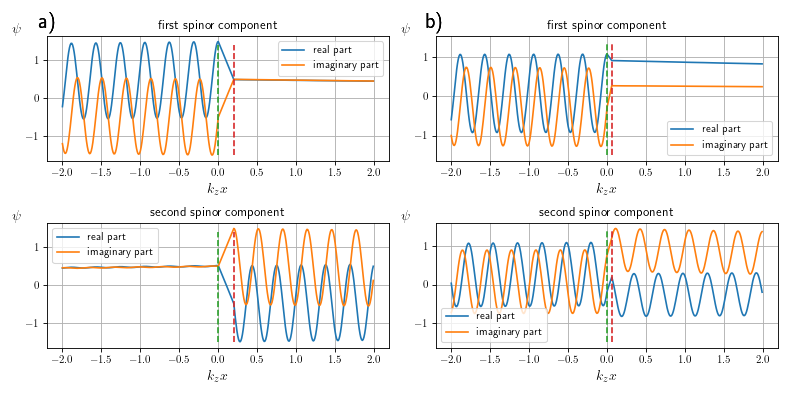

In [34]:
# %matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100, tight_layout=True, facecolor='white')

y_int = np.arange(-1.5, 1.5, 0.1)

axs_title = ["first spinor component", "second spinor component"]
region_lbl = ["a)", "b)"]
for i, k in enumerate(res.keys()):
    for j in range(res[k].shape[1]):
        axs[j, i].plot(x_range, res[k][:, j].real, label="real part")
        axs[j, i].plot(x_range, res[k][:, j].imag, label="imaginary part")

        axs[j, i].plot(np.full(len(y_int), 0), [i for i in y_int], linestyle = "dashed")
        axs[j, i].plot(np.full(len(y_int), k), [i for i in y_int], linestyle = "dashed")
        
        axs[j, i].set_title(axs_title[j])
        
        axs[j, i].set_xlabel(r"$k_z x$", fontsize=13)
        axs[j, i].set_ylabel(r"$\psi$", loc = 'top', rotation=0, fontsize=13)
        axs[j, i].legend()
        axs[j, i].grid(True)

        axs[0, i].text(0, 1.1, region_lbl[i], fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[0, i].transAxes)

    
# plt.savefig("plots/Report/Dirac_dilema_wavefuncton.pdf", transparent = True)
plt.show()

In [645]:
phi_range = np.arange(0.0001, 4, 0.01)
ee = 0
al_r = 10

alpha = [al_r, 0, -al_r]

coeff_norm = np.zeros((len(phi_range), 4))
ee = -.9999999
for j, i in enumerate(phi_range):
    profile = [0, i]
    junction = RachbaJunction([profile, alpha])
    S = junction.get_scattering_matrix(ee)
    M = junction.transfer_matrix_at(0, ee)
    
    junction.E_so = junction[1]

    coeff = np.dot(S.C, np.array([1, 0]))
    left_coeff = np.array([1, coeff[0], coeff[2], 0])        
    res = np.dot(M, left_coeff)
    
    coeff_norm[j]=np.abs(res)
#     coeff_norm[j]=np.angle(res)

In [ ]:
%matplotlib notebook
# plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(4, 1, figsize=(10, 5), 
                                dpi=100,
                                tight_layout=True,
                                facecolor='white')

for j, i in enumerate(axs):
    if j == 0:
        i.plot(phi_range, coeff_norm[:,j])
        i.plot(phi_range, coeff_norm[:,j+1])   
    elif j == 2:
        i.plot(phi_range, coeff_norm[:,j])
        i.plot(phi_range, coeff_norm[:,j+1])        
    else:
        i.plot(phi_range, coeff_norm[:,j])
    i.grid(True)

In [19]:
ee_range = np.arange(-.999, .999, 0.01)
ee = 0
al_r = 10

alpha = [al_r, 0, -al_r]

coeff_norm = np.zeros((len(ee_range), 4))
phi = 0.5
profile = [0, phi]
junction = RachbaJunction([profile, alpha])
for j, i in enumerate(ee_range):
    
    S = junction.get_scattering_matrix(i)
    M = junction.transfer_matrix_at(0, i)
    
    junction.E_so = junction[1]

    coeff = np.dot(S.C, np.array([1, 0]))
    left_coeff = np.array([1, coeff[0], coeff[2], 0])        
    res = np.dot(M, left_coeff)
    
    coeff_norm[j]=np.abs(res)
#     coeff_norm[j]=np.angle(res)

<IPython.core.display.Javascript object>


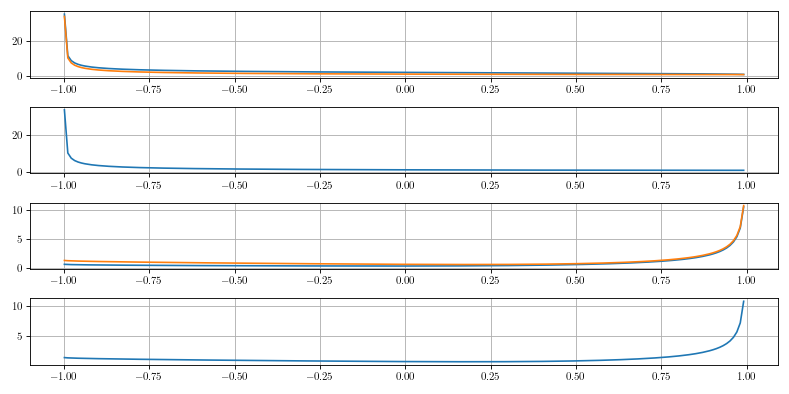

In [25]:
%matplotlib notebook
# plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(4, 1, figsize=(10, 5), 
                                dpi=100,
                                tight_layout=True,
                                facecolor='white')

for j, i in enumerate(axs):
    if j == 0:
        i.plot(ee_range, coeff_norm[:,j])
        i.plot(ee_range, coeff_norm[:,j+1])
    elif j == 2:
        i.plot(ee_range, coeff_norm[:,j])
        i.plot(ee_range, coeff_norm[:,j+1])        
    else:
        i.plot(ee_range, coeff_norm[:,j])
    i.grid(True)

In [642]:
alpha = [10, 0, -10]

profile = [0, 1]

junction = RachbaJunction([profile, alpha])
# S = junction.get_scattering_matrix(ee)
# M = junction.transfer_matrix_at(0, ee)


junction.E_so = junction[1]
wf = junction.get_WF(0, -.9999999)

print(wf)
print(junction.wave_length)

[[ 0.70710678+0.j  0.70710678+0.j -0.70710678-0.j -0.70710678+0.j]
 [ 0.70710678+0.j  0.70710678+0.j  0.70710678+0.j  0.70710678+0.j]]
[array([0.        , 0.00031623]), array([-0.        , -0.00031623]), array([0.        , 1.41421353]), array([-0.        , -1.41421353])]


In [636]:
np.sqrt(2)

1.4142135623730951